In [1]:
# Import necessary modules
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import sys

here = os.path.dirname(os.path.abspath("__file__"))
project_root = os.path.abspath(os.path.join(here, '../../'))
sys.path.insert(0, project_root)

from core.mpc.mpc import MPC
from core.mpc.mpc_params import MPCParams
from core.mpc.mpc_bounds import ControlInputBounds

from core.model.model_carrying_capacities import ModelCarryingCapacities
from core.model.model_disturbances import ModelDisturbances
from core.model.model_growth_rates import ModelGrowthRates
from core.model.model_initial_conditions import ModelInitialConditions
from core.model.model_params import ModelParams
from core.model.model_typical_disturbances import ModelTypicalDisturbances
from core.model.model_sensitivities import ModelSensitivities

from core.ga.ga_member import Member
from core.ga.ga_params import GeneticAlgorithmParams

from core.plotting.plotting import *

## Model Parameters

In [2]:
# Set ModelParams (time stepping)
model_params = ModelParams(
    dt               = 1,  # hours/step
    simulation_hours = 2900, # hours
    closed_form      = False,
    verbose          = True
)

In [3]:
# Set ModelCarryingCapacities
carrying_capacities = ModelCarryingCapacities(
    kh = 3.0,  # m
    kA = 0.65, # m2
    kN = 20,   # number of leaves
    kc = 1000, # number of spikelets
    kP = 0.25  # kg
)

In [4]:
# Set ModelGrowthRates
growth_rates = ModelGrowthRates(
    ah = 0.01,   # 1/hr
    aA = 0.0105, # 1/hr
    aN = 0.011,  # 1/hr
    ac = 0.01,   # 1/hr
    aP = 0.005   # 1/hr
)

In [5]:
# Set ModelSensitivities
sensitivities = ModelSensitivities(
    sigma_W = 30,  # hrs
    sigma_F = 300, # hrs
    sigma_T = 30,  # hrs
    sigma_R = 30   # hrs
)

In [6]:
# Set ModelInitialConditions
initial_conditions = ModelInitialConditions(
    h0=carrying_capacities.kh/model_params.simulation_hours, # m/hr
    A0=carrying_capacities.kA/model_params.simulation_hours, # m2/hr
    N0=carrying_capacities.kN/model_params.simulation_hours, # number/hr
    c0=carrying_capacities.kc/model_params.simulation_hours, # number/hr
    P0=carrying_capacities.kP/model_params.simulation_hours  # kg/hr
)

## MPC params and bounds

In [7]:
mpc_params = MPCParams(
    hourly_horizon=10,
    solver          = "ipopt",
    solver_options  = {
        "tol": 1e-4,          # looser tolerance than default 1e-8
        "acceptable_iter": 100, # stop earlier if acceptable
        "max_iter": 500,      # limit iterations so it doesn't grind forever
        "print_level": 5,     # moderate verbosity
        "mu_strategy": "adaptive",
        "linear_solver": "mumps",
    },
    reoptimization_interval=5
)
bounds = ControlInputBounds()

## Input Disturbances

In [8]:
# Hourly precipitation, radiation, and temperature from CSV
hourly_input_disturbances = pd.read_csv(
    '../../io/inputs/hourly_prcp_rad_temp_iowa.csv'
)

In [9]:
# Set ModelDisturbances
input_disturbances = ModelDisturbances(
    precipitation = 0.5*hourly_input_disturbances['Hourly Precipitation (in)'].to_numpy(), # imagine it's a drought year
    radiation     = hourly_input_disturbances['Hourly Radiation (W/m2)'].to_numpy(),
    temperature   = hourly_input_disturbances['Temperature (C)'].to_numpy()
)

## Plot disturbances

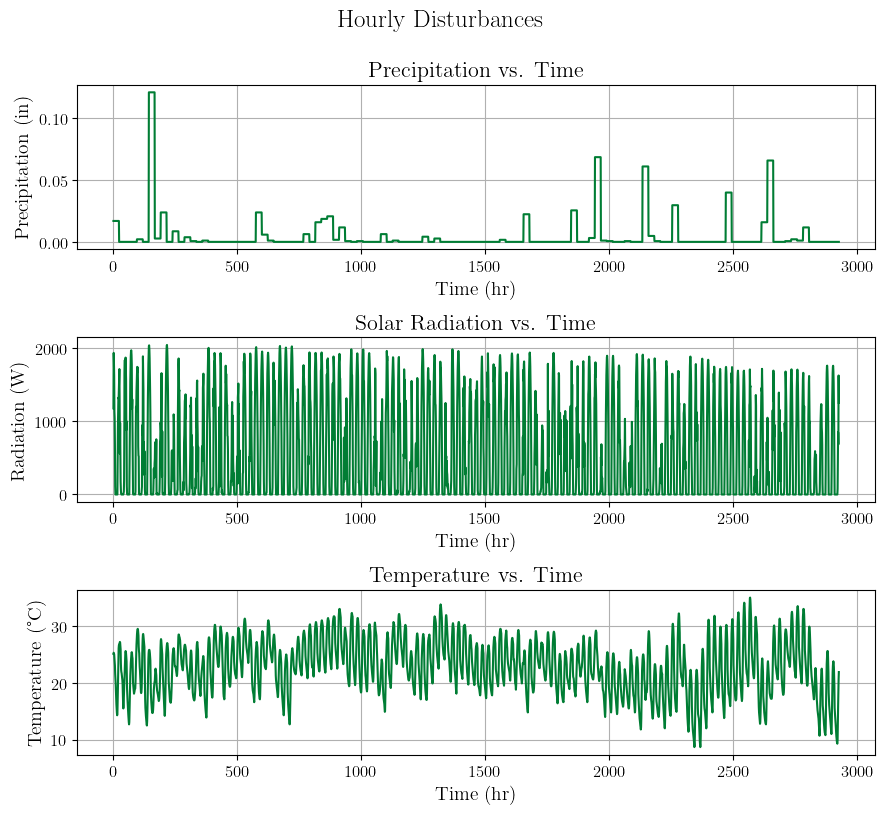

In [10]:
plot_hourly_inputs(
    input_disturbances
)

In [11]:
# Convert inputs from hourly to simulation time steps
from core.model.model_helpers import get_sim_inputs_from_hourly
simulation_hours = len(input_disturbances.precipitation)
temperature   = get_sim_inputs_from_hourly(input_disturbances.temperature,   model_params.dt, simulation_hours, mode='split')
radiation     = get_sim_inputs_from_hourly(input_disturbances.radiation,     model_params.dt, simulation_hours, mode='split')
precipitation = get_sim_inputs_from_hourly(input_disturbances.precipitation, model_params.dt, simulation_hours, mode='split')

## Optimal/Typical Values

In [12]:
default_typical_disturbances = ModelTypicalDisturbances()

typical_disturbances = ModelTypicalDisturbances(
    typical_water       = default_typical_disturbances.typical_water * model_params.dt,
    typical_fertilizer  = default_typical_disturbances.typical_fertilizer * model_params.dt,
    typical_temperature = default_typical_disturbances.typical_temperature * model_params.dt,
    typical_radiation   = default_typical_disturbances.typical_radiation * model_params.dt
)

## Simulation of Plant Growth over Season

In [13]:
# Construct an instance of the Member class and get the cost
mpc = MPC(
    carrying_capacities  = carrying_capacities,
    disturbances         = input_disturbances,
    growth_rates         = growth_rates,
    initial_conditions   = initial_conditions,
    model_params         = model_params,
    typical_disturbances = typical_disturbances,
    sensitivities        = sensitivities,
    mpc_params           = mpc_params,
    bounds               = bounds
)

In [14]:
# Run the MPC
mpc_result = mpc.run()

# Save the result(
with open('mpc_nonlinear_result.pkl', 'wb') as f:
    pickle.dump(mpc_result, f)

[Daily MPC] Day 1/120, hour index 0
[CFTOC] Solver status: ok, termination: optimal
[Daily MPC] Day 2/120, hour index 24
[CFTOC] Solver status: ok, termination: optimal
[Daily MPC] Day 3/120, hour index 48
[CFTOC] Solver status: ok, termination: optimal
[Daily MPC] Day 4/120, hour index 72
[CFTOC] Solver status: ok, termination: optimal
[Daily MPC] Day 5/120, hour index 96
[CFTOC] Solver status: ok, termination: optimal
[Daily MPC] Day 6/120, hour index 120
[CFTOC] Solver status: ok, termination: optimal
[Daily MPC] Day 7/120, hour index 144
[CFTOC] Solver status: ok, termination: optimal
[Daily MPC] Day 8/120, hour index 168
[CFTOC] Solver status: ok, termination: optimal
[Daily MPC] Day 9/120, hour index 192
[CFTOC] Solver status: ok, termination: optimal
[Daily MPC] Day 10/120, hour index 216
[CFTOC] Solver status: ok, termination: optimal
[Daily MPC] Day 11/120, hour index 240
[CFTOC] Solver status: ok, termination: optimal
[Daily MPC] Day 12/120, hour index 264
[CFTOC] Solver stat

# Read-in the results for plotting

In [15]:
# Open the pickled MPC result
with open('mpc_nonlinear_result.pkl', 'rb') as f:
    mpc_result = pickle.load(f)

In [16]:
h = mpc_result["h"]
A = mpc_result["A"]
N = mpc_result["N"]
c = mpc_result["c"]
P = mpc_result["P"]

irrigation = mpc_result["irrigation"]
fertilizer = mpc_result["fertilizer"]

delayed_water = mpc_result["logs"]["delayed_water"]
delayed_fertilizer = mpc_result["logs"]["delayed_fertilizer"]
delayed_temperature = mpc_result["logs"]["delayed_temperature"]
delayed_radiation = mpc_result["logs"]["delayed_radiation"]

cumulative_water = mpc_result["logs"]["cumulative_water"]
cumulative_fertilizer = mpc_result["logs"]["cumulative_fertilizer"]
cumulative_temperature = mpc_result["logs"]["cumulative_temperature"]
cumulative_radiation = mpc_result["logs"]["cumulative_radiation"]

cumulative_divergence_water = mpc_result["logs"]["cumulative_divergence_water"]
cumulative_divergence_fertilizer = mpc_result["logs"]["cumulative_divergence_fertilizer"]
cumulative_divergence_temperature = mpc_result["logs"]["cumulative_divergence_temperature"]
cumulative_divergence_radiation = mpc_result["logs"]["cumulative_divergence_radiation"]

nuWs = mpc_result["logs"]["nuW"]
nuFs = mpc_result["logs"]["nuF"]
nuTs = mpc_result["logs"]["nuR"]
nuRs = mpc_result["logs"]["nuT"]

## Plot crop growth results

/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:197: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()
/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:205: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()
/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:213: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ign

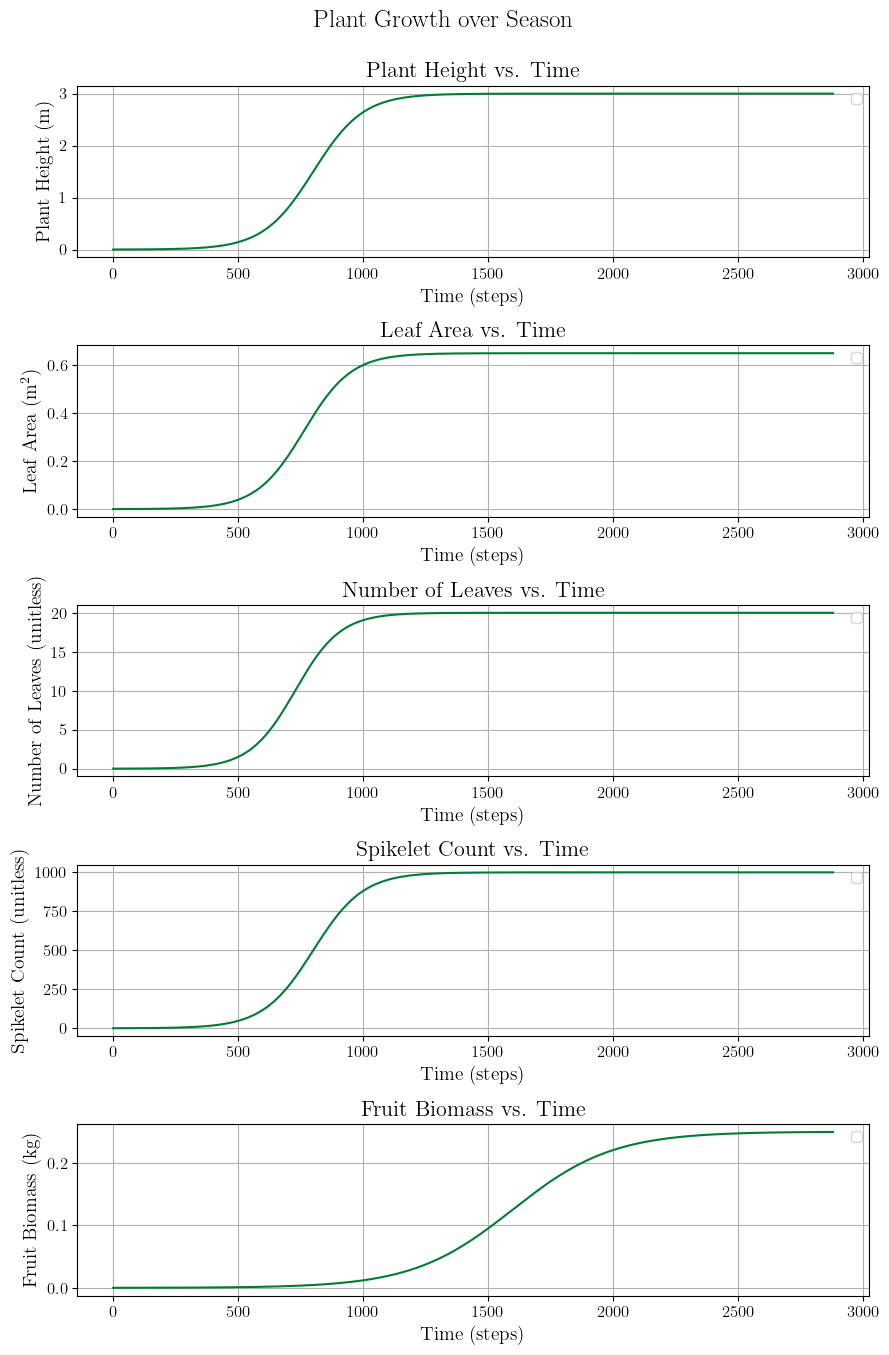

In [17]:
plot_crop_growth_results(
    hs = [h],
    As = [A],
    Ns = [N],
    cs = [c],
    Ps = [P]
)

In [18]:
ga_params = GeneticAlgorithmParams()

profit = ga_params.weight_fruit_biomass * P[-1]
expenses = (ga_params.weight_irrigation * np.sum(irrigation)
            + ga_params.weight_fertilizer * np.sum(fertilizer))
revenue = profit - expenses

print(f'Height: {h[-1]}')
print(f'Fruit biomass: {P[-1]}')

print(f'Irrigation used (in): {np.sum(irrigation):.2f}, irrigation expense: ${ga_params.weight_irrigation * np.sum(irrigation):.2f}')
print(f'Fertilizer used (lbs): {np.sum(fertilizer):.2f}, fertilizer expense: ${ga_params.weight_fertilizer * np.sum(fertilizer):.2f}')

print(f'Profit: ${profit:.2f}')
print(f'Expenses: ${expenses:.2f}')

print(f'\n')

print(f'Revenue: ${revenue:.2f}')

Height: 2.9999999974674956
Fruit biomass: 0.24959513127796965
Irrigation used (in): 1.34, irrigation expense: $2.67
Fertilizer used (lbs): 8.43, fertilizer expense: $5.18
Profit: $1110.70
Expenses: $7.85


Revenue: $1102.85


## Plot input and disturbance evolution with delays taken into account

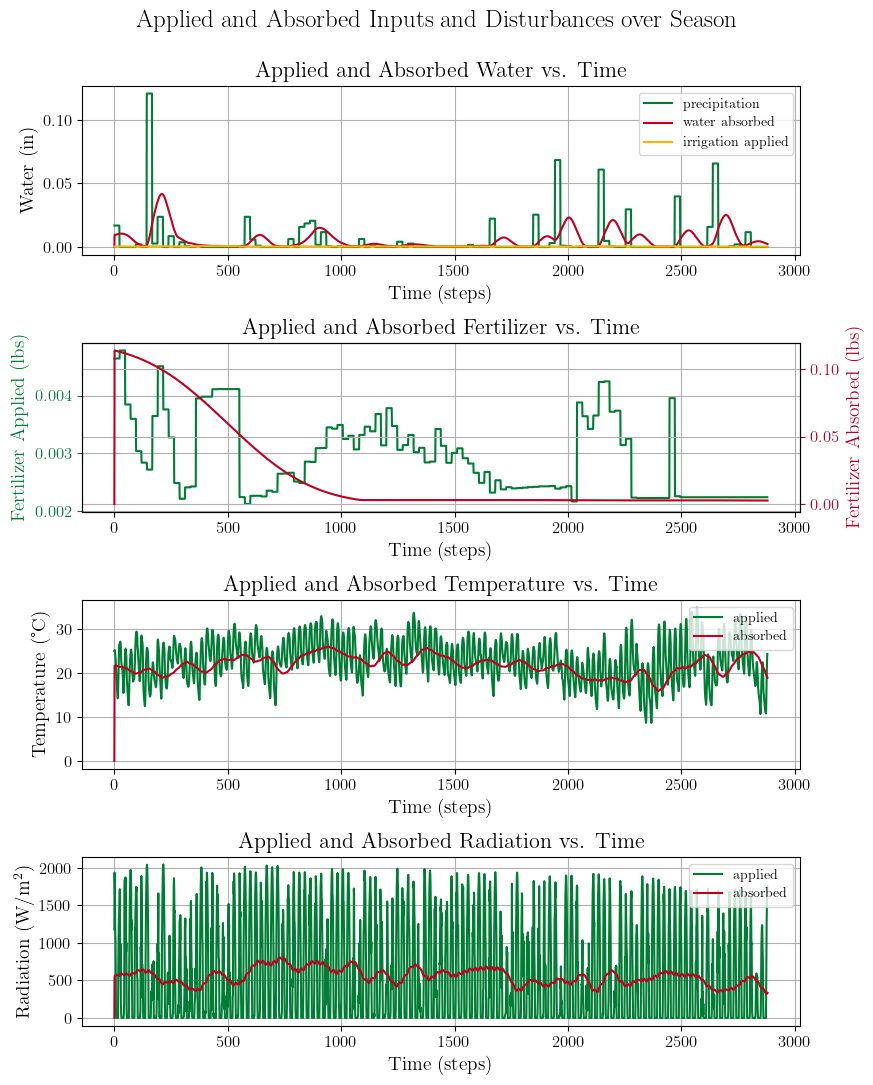

In [19]:
plot_applied_vs_absorbed(
        irrigation,
        precipitation[0:len(irrigation)],
        delayed_water,
        fertilizer,
        delayed_fertilizer,
        temperature[0:len(irrigation)],
        delayed_temperature,
        radiation[0:len(irrigation)],
        delayed_radiation
)

In [20]:
# 1) Hourly totals
total_irrigation_hourly = irrigation.sum()
total_fertilizer_hourly = fertilizer.sum()

print("Total irrigation from hourly array:", total_irrigation_hourly)
print("Total fertilizer from hourly array:", total_fertilizer_hourly)

# 2) Cumulative totals used in the second plot
total_water_cum = cumulative_water[-1] - cumulative_water[0]
total_fert_cum  = cumulative_fertilizer[-1]  - cumulative_fertilizer[0]

print("Total water from cumulative curve:", total_water_cum)
print("Total fert from cumulative curve:", total_fert_cum)

# 3) Absorbed/delayed signals logged:
total_absorbed_water = delayed_water.sum()
total_absorbed_fert  = delayed_fertilizer.sum()

print("Total absorbed water:", total_absorbed_water)
print("Total absorbed fert:", total_absorbed_fert)


Total irrigation from hourly array: 1.3363923101297155
Total fertilizer from hourly array: 8.428369282200864
Total water from cumulative curve: 16.651613047268366
Total fert from cumulative curve: 65.06227565802494
Total absorbed water: 16.651613047268384
Total absorbed fert: 65.062275658025


## Plot cumulative value evolution

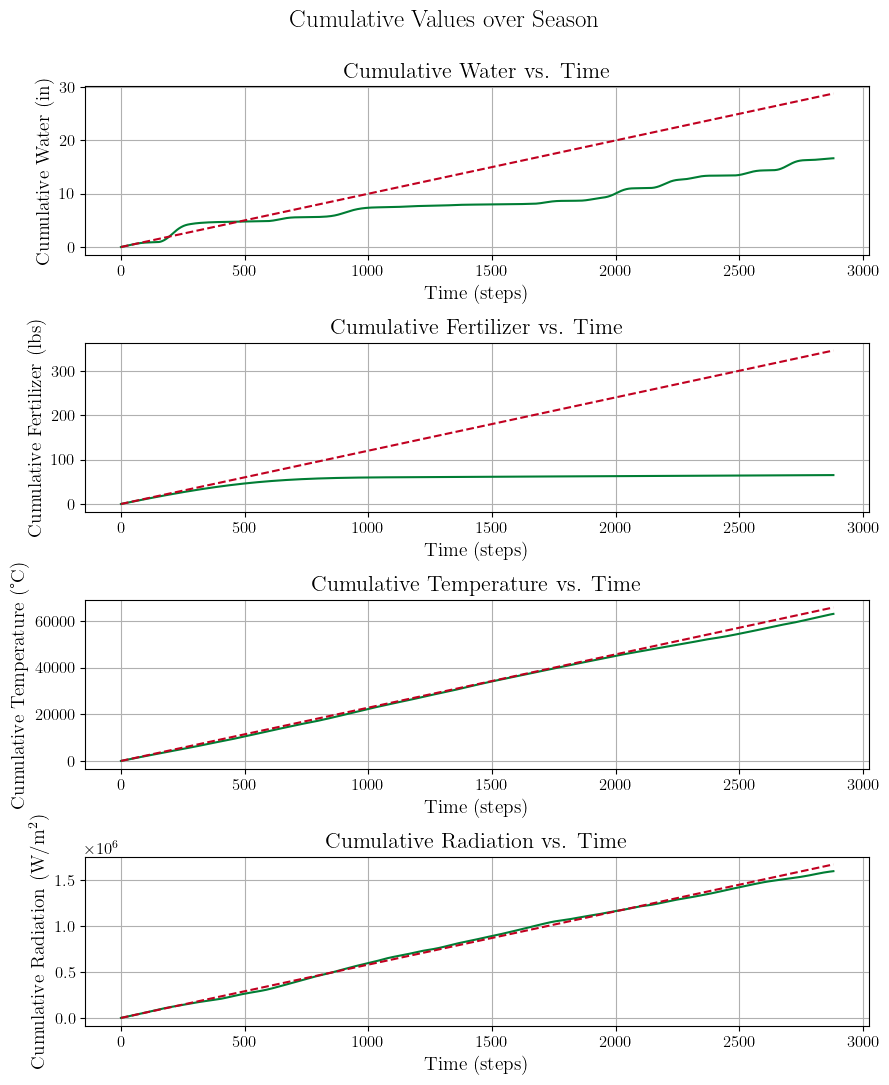

In [21]:
plot_cumulative_values(
    cumulative_water,
    cumulative_fertilizer,
    cumulative_temperature,
    cumulative_radiation,
    typical_disturbances
)

## Plot the deltas between actual and expected cumulative value

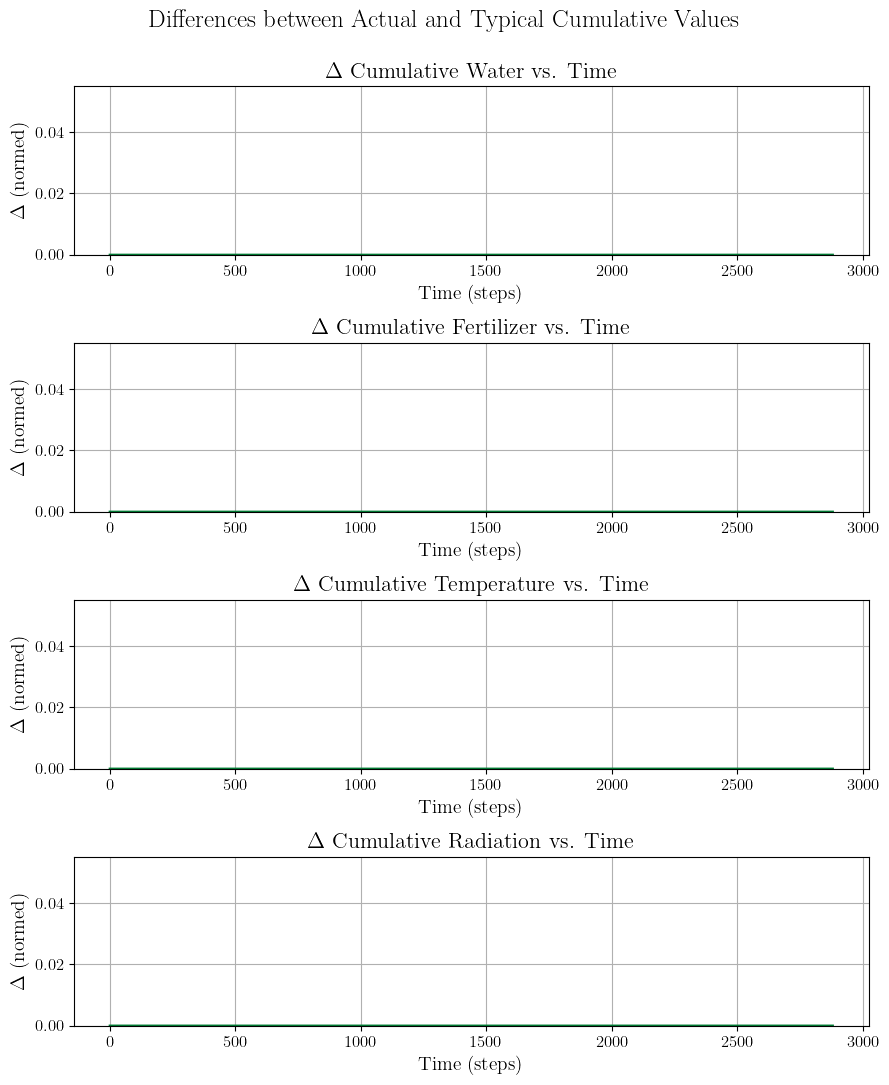

In [22]:
plot_actual_vs_expected_cumulatives(
    cumulative_divergence_water,
    cumulative_divergence_fertilizer,
    cumulative_divergence_temperature,
    cumulative_divergence_radiation
)

## Plot nutrient factor evolution

/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:514: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()
/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:524: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()
/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:534: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ign

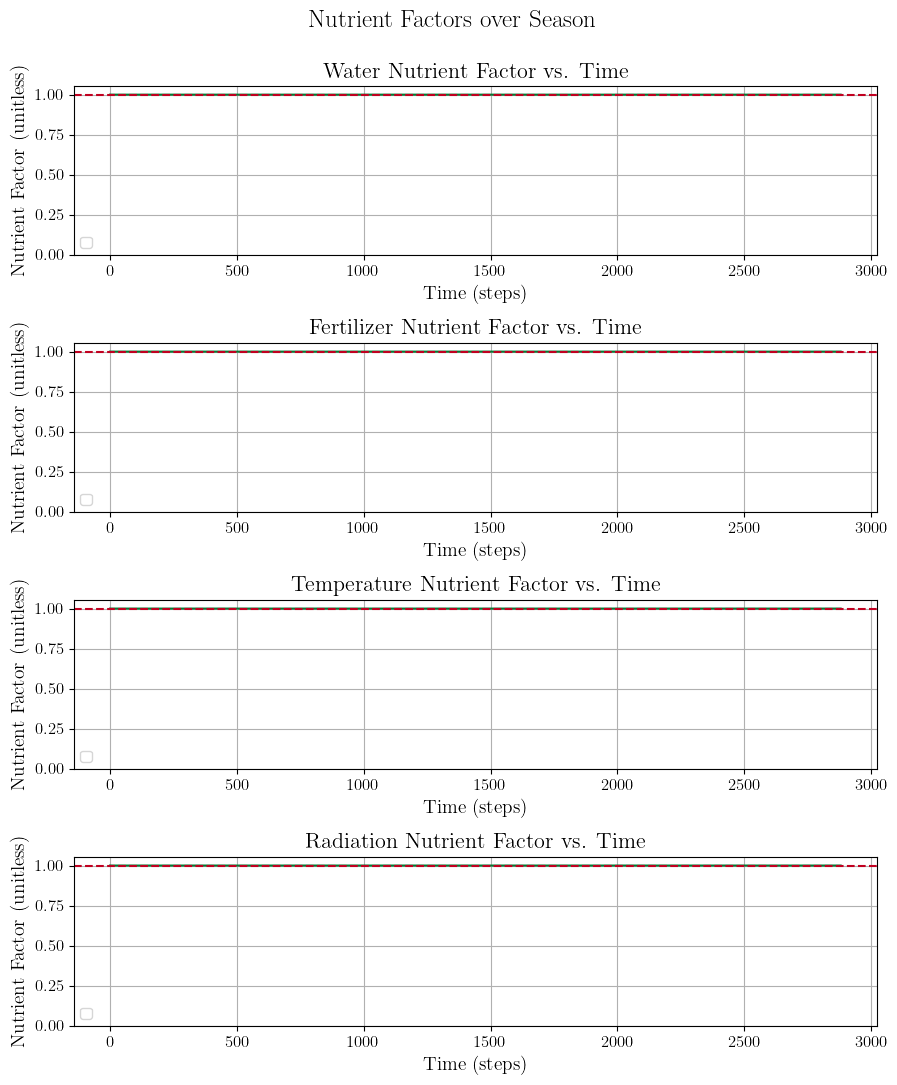

In [23]:
plot_nutrient_factor_evolution(
    [nuWs],
    [nuFs],
    [nuTs],
    [nuRs]
)

## Run same simulation with Member cost function from GA

In [24]:
model_params = ModelParams(
    dt               = 1.0,  # hours/step
    simulation_hours = 2900, # hours
    closed_form      = True,
    verbose          = True
)

ga_params = GeneticAlgorithmParams()
weight_fruit_biomass = ga_params.weight_fruit_biomass
weight_irrigation    = ga_params.weight_irrigation
weight_fertilizer    = ga_params.weight_fertilizer

default_typical_disturbances = ModelTypicalDisturbances()
typical_disturbances = ModelTypicalDisturbances(
    typical_water       = default_typical_disturbances.typical_water * model_params.dt,
    typical_fertilizer  = default_typical_disturbances.typical_fertilizer * model_params.dt,
    typical_temperature = default_typical_disturbances.typical_temperature * model_params.dt,
    typical_radiation   = default_typical_disturbances.typical_radiation * model_params.dt
)

ga_params = GeneticAlgorithmParams()

In [25]:
appended_irrigation = np.append(irrigation, (model_params.total_time_steps - len(irrigation)) * [0])

appended_irrigation = get_sim_inputs_from_hourly(appended_irrigation, model_params.dt, model_params.simulation_hours, mode='split')

appended_fertilizer = np.append(fertilizer, (model_params.total_time_steps - len(fertilizer)) * [0])
appended_fertilizer = get_sim_inputs_from_hourly(appended_fertilizer, model_params.dt, model_params.simulation_hours, mode='split')

In [26]:
member = Member(
    ga_params            = ga_params,
    carrying_capacities  = carrying_capacities,
    disturbances         = input_disturbances,
    growth_rates         = growth_rates,
    initial_conditions   = initial_conditions,
    model_params         = model_params,
    typical_disturbances = typical_disturbances,
    sensitivities        = sensitivities,
    values               = np.array([1, 0, 1, 0]) # dummy values
)
member.get_cost(irrigation=appended_irrigation, fertilizer=appended_fertilizer)

-1103.0198513832738

In [27]:
# Read results from the output csv file
output = pd.read_csv('output_get_cost.csv')

h = output['h'].to_numpy()
A = output['A'].to_numpy()
N = output['N'].to_numpy()
c = output['c'].to_numpy()
P = output['P'].to_numpy()

delayed_water       = output['delayed_water'].to_numpy()
delayed_fertilizer  = output['delayed_fertilizer'].to_numpy()
delayed_temperature = output['delayed_temperature'].to_numpy()
delayed_radiation   = output['delayed_radiation'].to_numpy()

cumulative_water       = output['cumulative_water'].to_numpy()
cumulative_fertilizer  = output['cumulative_fertilizer'].to_numpy()
cumulative_temperature = output['cumulative_temperature'].to_numpy()
cumulative_radiation   = output['cumulative_radiation'].to_numpy()

cumulative_divergence_water       = output['cumulative_divergence_water'].to_numpy()
cumulative_divergence_fertilizer  = output['cumulative_divergence_fertilizer'].to_numpy()
cumulative_divergence_temperature = output['cumulative_divergence_temperature'].to_numpy()
cumulative_divergence_radiation   = output['cumulative_divergence_radiation'].to_numpy()

nuWs = output['nuW'].to_numpy()
nuFs = output['nuF'].to_numpy()
nuTs = output['nuT'].to_numpy()
nuRs = output['nuR'].to_numpy()

ah_hat = output['ah_hat'].to_numpy()
aA_hat = output['aA_hat'].to_numpy()
aN_hat = output['aN_hat'].to_numpy()
ac_hat = output['ac_hat'].to_numpy()
aP_hat = output['aP_hat'].to_numpy()

kh_hat = output['kh_hat'].to_numpy()
kA_hat = output['kA_hat'].to_numpy()
kN_hat = output['kN_hat'].to_numpy()
kc_hat = output['kc_hat'].to_numpy()
kP_hat = output['kP_hat'].to_numpy()

/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:197: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()
/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:205: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()
/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:213: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ign

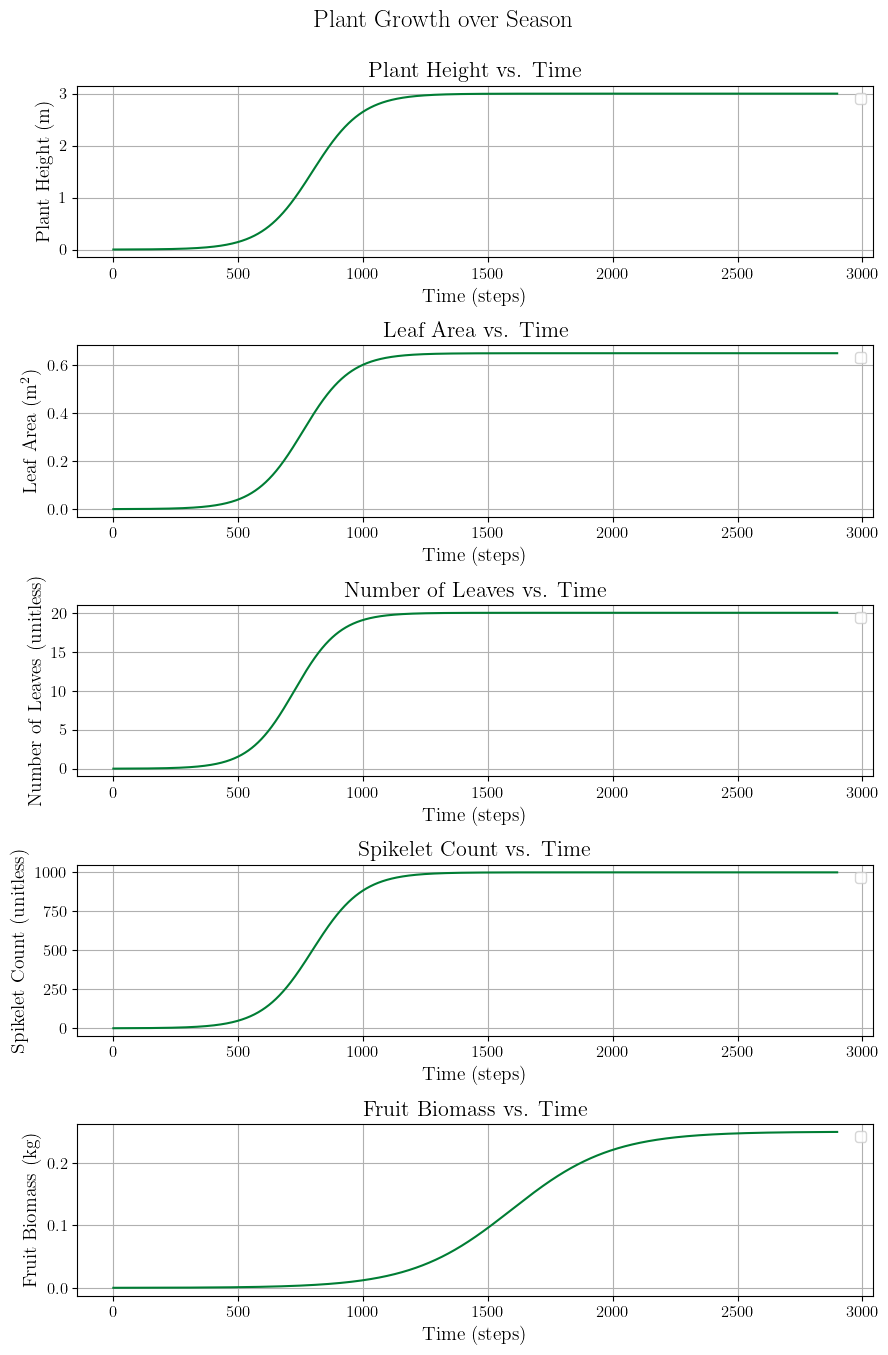

In [28]:
plot_crop_growth_results(
    hs = [h],
    As = [A],
    Ns = [N],
    cs = [c],
    Ps = [P]
)

In [29]:
profit = weight_fruit_biomass * P[-1]
expenses = (weight_irrigation * np.sum(irrigation)
            + weight_fertilizer * np.sum(fertilizer))
revenue = profit - expenses

print(f'weight_fruit_biomass: {weight_fruit_biomass}')
print(f'weight_irrigation: {weight_irrigation}')
print(f'weight_fertilizer: {weight_fertilizer}')
print(f'Fruit biomass: {P[-1]}')

print(f'\n')

print(f'Profit: ${profit:.2f}')
print(f'Irrigation used (in): {np.sum(irrigation):.2f}, irrigation expense: ${weight_irrigation * np.sum(irrigation):.2f}')
print(f'Fertilizer used (lbs): {np.sum(fertilizer):.2f}, fertilizer expense: ${weight_fertilizer * np.sum(fertilizer):.2f}')
print(f'Expenses: ${expenses:.2f}')
print(f'Revenue: ${revenue:.2f}')

weight_fruit_biomass: 4450
weight_irrigation: 2.0
weight_fertilizer: 0.614
Fruit biomass: 0.2496331808410797


Profit: $1110.87
Irrigation used (in): 1.34, irrigation expense: $2.67
Fertilizer used (lbs): 8.43, fertilizer expense: $5.18
Expenses: $7.85
Revenue: $1103.02


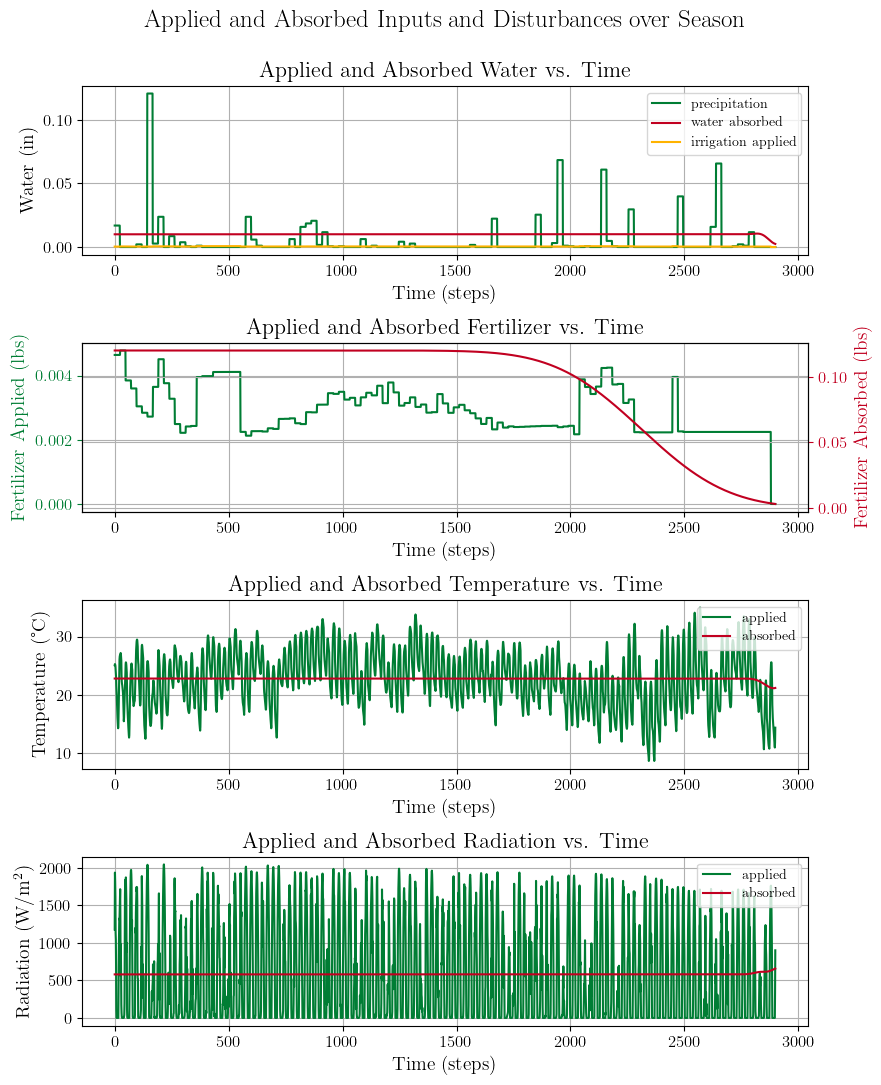

In [30]:
irrigation    = get_sim_inputs_from_hourly(appended_irrigation,              model_params.dt, model_params.simulation_hours, mode='split')
fertilizer    = get_sim_inputs_from_hourly(appended_fertilizer,              model_params.dt, model_params.simulation_hours, mode='split')
temperature   = get_sim_inputs_from_hourly(input_disturbances.temperature,   model_params.dt, model_params.simulation_hours, mode='split')
radiation     = get_sim_inputs_from_hourly(input_disturbances.radiation,     model_params.dt, model_params.simulation_hours, mode='split')
precipitation = get_sim_inputs_from_hourly(input_disturbances.precipitation, model_params.dt, model_params.simulation_hours, mode='split')

plot_applied_vs_absorbed(
        irrigation,
        precipitation[0:len(irrigation)],
        delayed_water,
        fertilizer,
        delayed_fertilizer,
        temperature,
        delayed_temperature,
        radiation,
        delayed_radiation
)

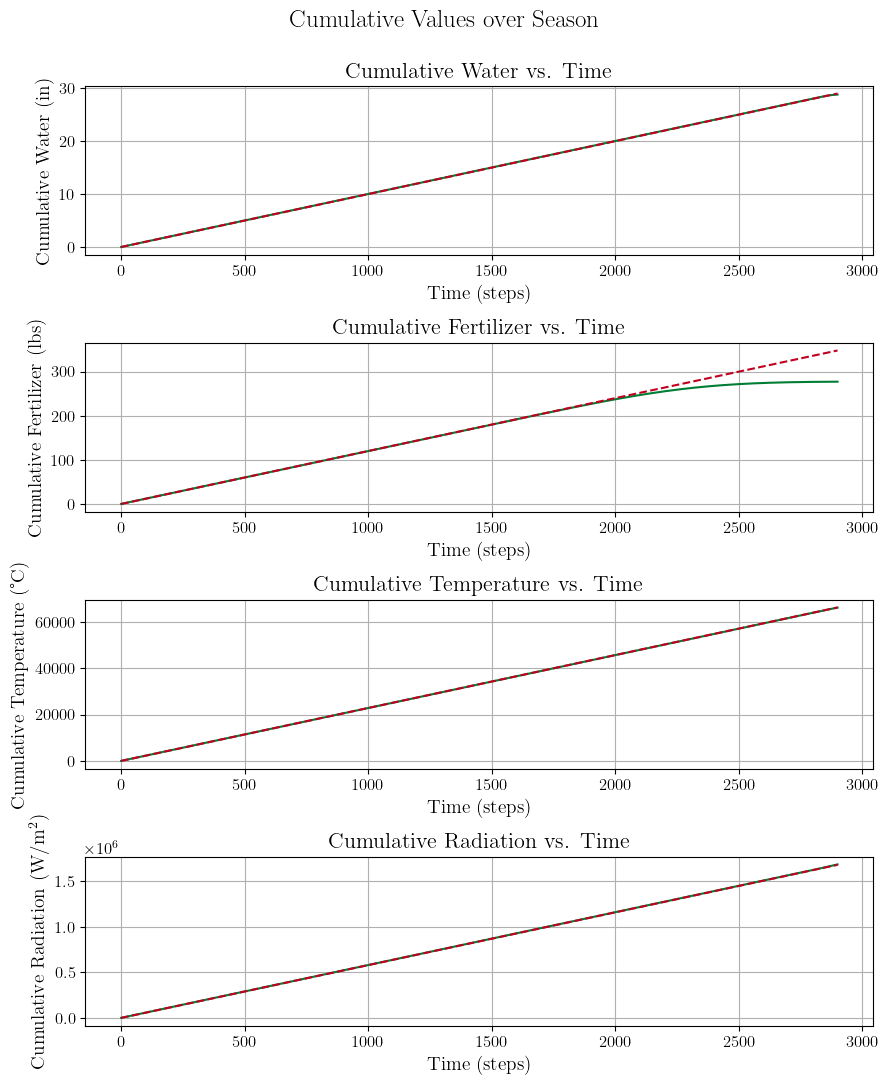

In [31]:
plot_cumulative_values(
    cumulative_water,
    cumulative_fertilizer,
    cumulative_temperature,
    cumulative_radiation,
    typical_disturbances
)

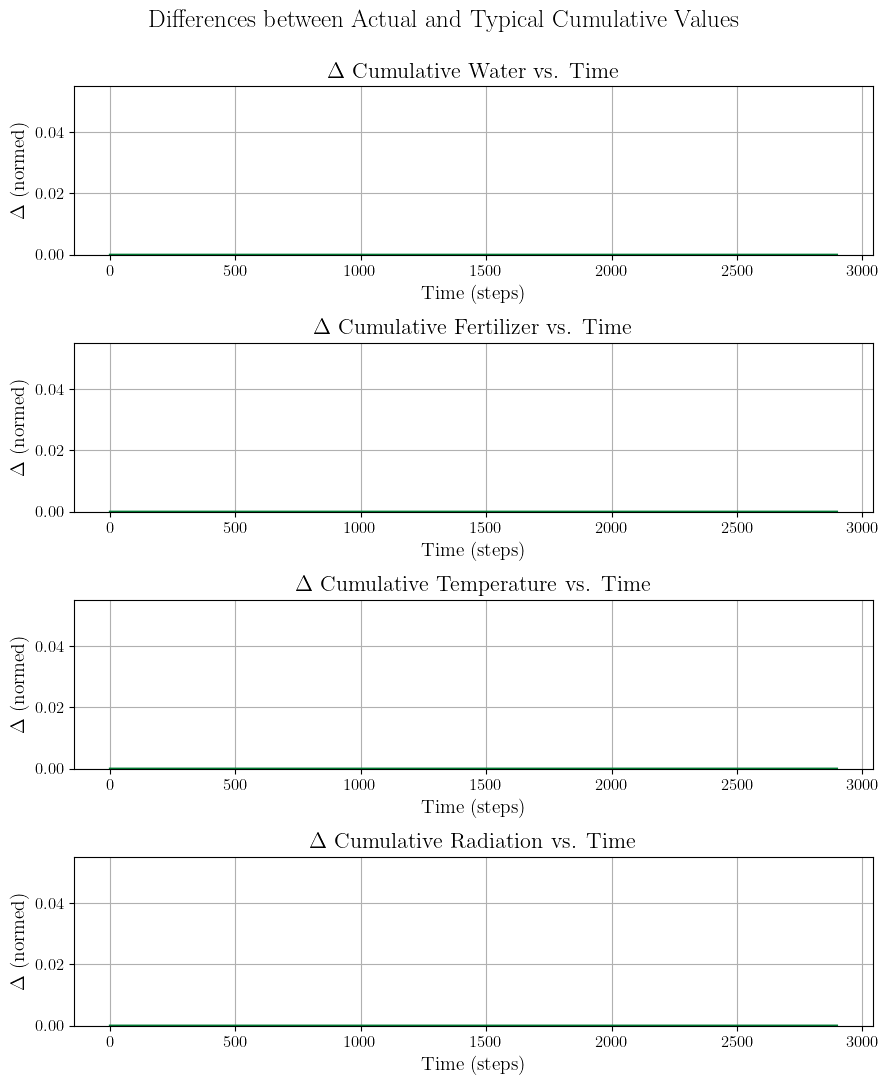

In [32]:
plot_actual_vs_expected_cumulatives(
    cumulative_divergence_water,
    cumulative_divergence_fertilizer,
    cumulative_divergence_temperature,
    cumulative_divergence_radiation
)

/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:514: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()
/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:524: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()
/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:534: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ign

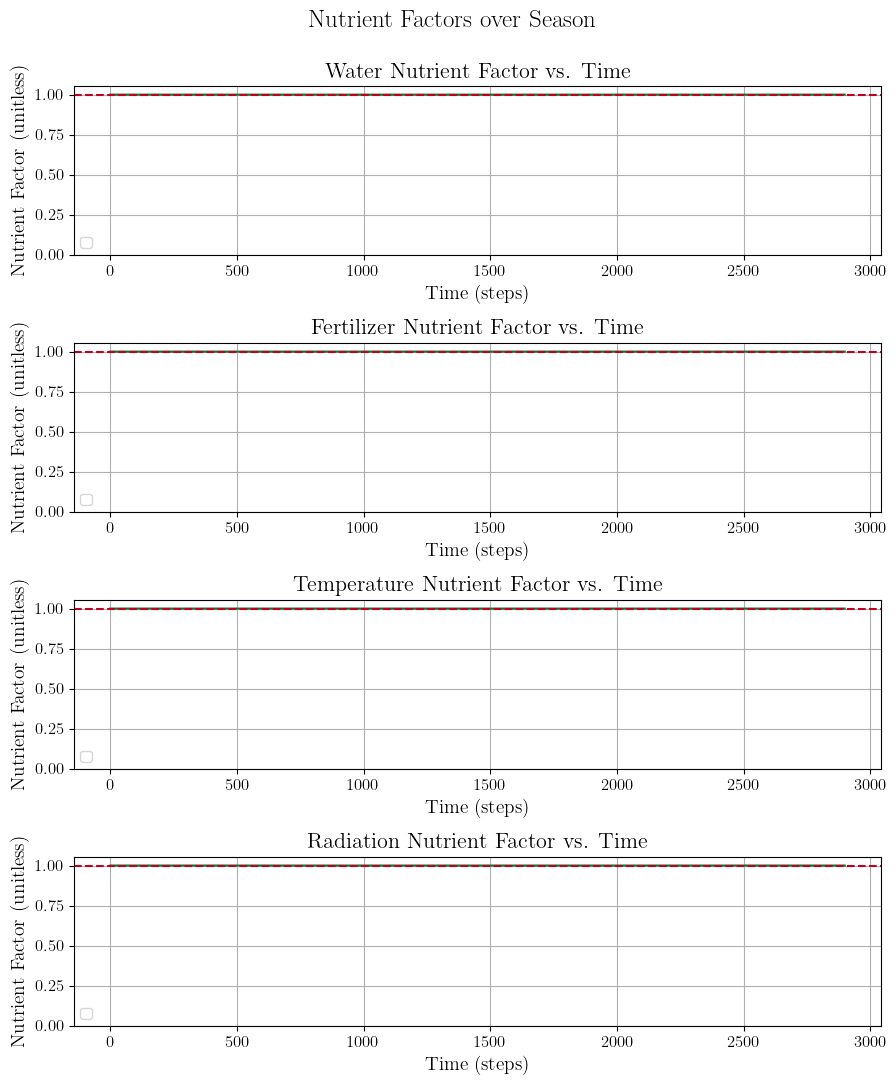

In [33]:
plot_nutrient_factor_evolution(
    [nuWs],
    [nuFs],
    [nuTs],
    [nuRs]
)

## Plot growth rate evolution

/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:603: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()
/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:613: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()
/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:623: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ign

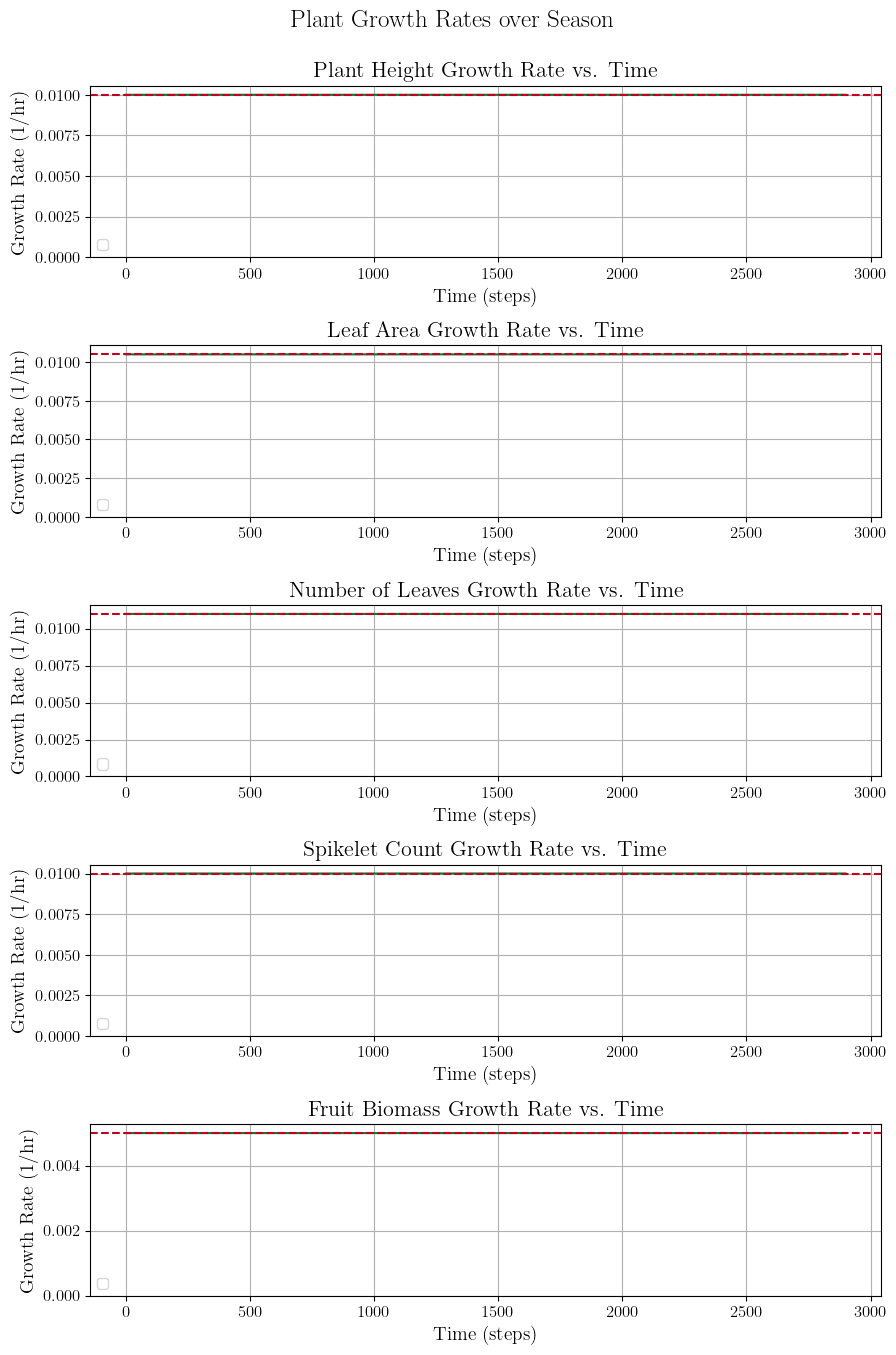

In [34]:
plot_growth_rate_evolution(
        growth_rates,
        [ah_hat],
        [aA_hat],
        [aN_hat],
        [ac_hat],
        [aP_hat],
)

## Plot carrying capacity evolution

/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:705: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()
/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:715: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()
/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:725: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ign

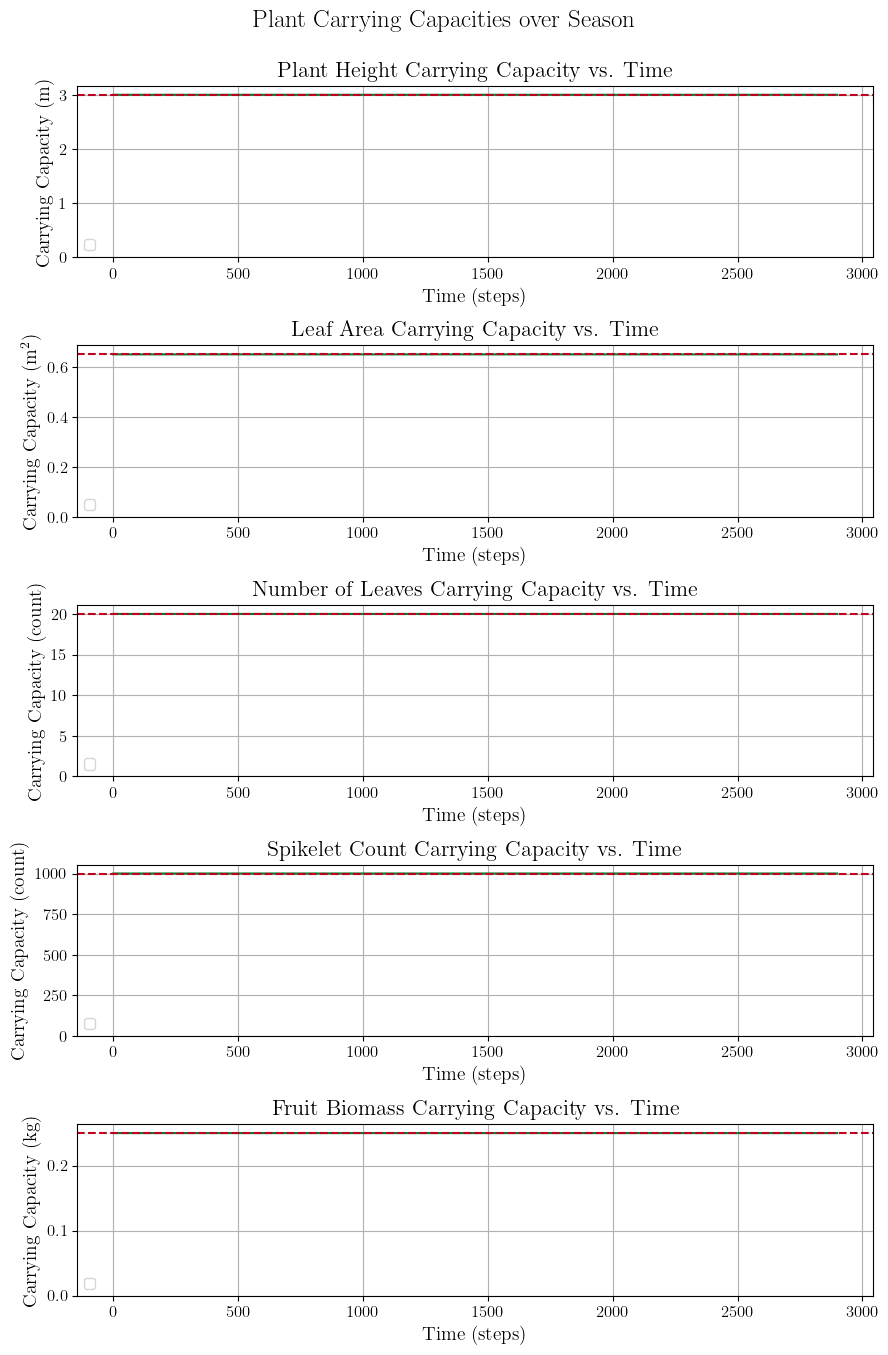

In [35]:
plot_carrying_capacity_evolution(
        carrying_capacities,
        [kh_hat],
        [kA_hat],
        [kN_hat],
        [kc_hat],
        [kP_hat]
)